In [1]:
%matplotlib inline
from pycocotools.coco import COCO
import os
import numpy as np
import random
import skimage.io as io
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pylab
import tensorflow as tf
import tensorflow.contrib.slim as slim
import tensorflow.contrib.slim.nets
from tensorflow.contrib.layers.python.layers import utils

import resnet_v2 as resnet
# import cv2
pylab.rcParams['figure.figsize'] = (10.0, 8.0)


In [2]:
def HourGlass(inputs,scope):
    
    levels_down = {}
    levels_up = {}
    LEVELS = 5
    net = inputs

    with tf.variable_scope(scope,"HourGlass1"):
        with tf.variable_scope("DownSample"):
            for i in range(LEVELS):
                if i == 0:
                    net = tf.layers.conv2d(net,64,(3,3),(2,2),'same',name="Conv{}".format(2*i),activation=tf.nn.relu)
                    levels_down[2*i] = net
                    net = tf.layers.conv2d(net,64,(3,3),(2,2),'same',name="Conv{}".format(2*i+1),activation=tf.nn.relu)
                    levels_down[2*i+1] = net
                else:
                    net = tf.layers.conv2d(net,32,(3,3),(1,1),'same',name="Conv{}".format(2*i),activation=tf.nn.relu)
                    levels_down[2*i] = net
                    net = tf.layers.conv2d(net,32,(3,3),(2,2),'same',name="Conv{}".format(2*i+1),activation=tf.nn.relu)
                    levels_down[2*i+1] = net
        with tf.variable_scope("Bottleneck"):
            net = tf.layers.conv2d(net,16,(1,1),(1,1),name="bottleneck")

        with tf.variable_scope("UpSample"):
            for i in reversed(range(LEVELS)):
                if i != 0:
                    net = tf.layers.conv2d_transpose(net,32,(3,3),(2,2),'same',name="TransposeConv{}".format(2*i+1),
                                                     activation=tf.nn.relu)
                    levels_up[2*i+1] = net
                    net = tf.layers.conv2d_transpose(net,32,(3,3),(1,1),'same',name="TransposeConv{}".format(2*i),
                                                     activation=tf.nn.relu)
                    levels_up[2*i] = net
                    net = tf.concat([net, levels_down[2*i]],axis=3)
                else:
                    net = tf.layers.conv2d_transpose(net,16,(3,3),(2,2),'same',name="TransposeConv{}".format(2*i+1),
                                                     activation=tf.nn.relu)
                    levels_up[2*i+1] = net
#                     net = tf.layers.conv2d_transpose(net,16,(3,3),(2,2),'same',name="TransposeConv{}".format(2*i),
#                                                      activation=tf.nn.relu)
#                     levels_up[2*i] = net
                    
    return net, levels_down, levels_up

In [3]:
# images = tf.placeholder(tf.float32,[1,256,256,3])

# net, levels_down, levels_up = HourGlass(images,"KyleNet")

# Initialize Dataset

In [6]:
def get_data(base_dir,image_dir,ann_file):
    image_path = '{}/images/{}'.format(baseDir,image_dir)
    ann_path='{}/annotations/{}.json'.format(baseDir,ann_file)

    return image_path, ann_path
    
# define the path to the annotation file corresponding to the images you want to work with
baseDir='/Users/kyle/Repositories/coco'

trainData='person_keypoints_train2014'
valData='person_keypoints_val2014'
testData='image_info_test-dev2015'

imageTrainDir = 'train2014'
imageValDir = 'val2014'
imageTestDir = 'test2015'

train_img_path, train_ann_path = get_data(baseDir,imageTrainDir,trainData)
val_img_path, val_ann_path = get_data(baseDir,imageValDir,valData)

# initialize a coco object
coco = COCO(train_ann_path)

# get all images containing the 'person' category
catIds = coco.getCatIds(catNms=['person'])
imgIds = coco.getImgIds(catIds=catIds)

# Just for dealing with the images on my computer (not necessary when working with the whole dataset)
catIds = imgIds[0:30]
imgIds = imgIds[0:30]
    

loading annotations into memory...
Done (t=8.76s)
creating index...
index created!


In [31]:
graph = tf.Graph()
with graph.as_default():
    
    VGG_MEAN = tf.reshape(tf.constant([123.68, 116.78, 103.94]),[1,1,3])
    NUM_KEYPOINTS = 17
    BATCH_SIZE = 10
    L = 10.0 # keypoint effective radius
    
    def extract_annotations(filename, imgID, coco=coco):
        anns = coco.loadAnns(coco.getAnnIds(imgID,catIds=[1],iscrowd=None))
        ann = max([ann for ann in anns], key=lambda item:item['area']) # extract annotation for biggest instance
        bbox = np.array(np.floor(ann['bbox']),dtype=int)
        keypoints = np.reshape(ann['keypoints'],(-1,3))
        mask = coco.annToMask(ann)
        
        return filename, bbox, keypoints, mask
    
    def preprocess_image_tf(filename, bbox_tensor, keypoints_tensor, mask, D = tf.constant(256.0)):
        """
        Returns:
        resized_image (N,D,D,3) - cropped, padded (if needed), scaled to square image of size D
        resized_mask (N,D,D,1) - cropped, padded (if needed), scaled to square mask of size D
        pts (N,2,17) - keypoint coordinates (i,j) scaled to match up with resized_image
        labels (N,1,17) - values corresponding to pts: {0: invalid, 1:occluded, 2:valid}
        """
        image_string = tf.read_file(filename)
        image_decoded = tf.image.decode_jpeg(image_string, channels=3)
        image = tf.cast(image_decoded, tf.float32)

        mask = tf.transpose([mask],[1,2,0])
        bbox_tensor = tf.to_float(bbox_tensor)
        keypoints_tensor = tf.to_float(keypoints_tensor)

        sideLength = tf.reduce_max(bbox_tensor[2:],axis=0)
        centerX = tf.floor(bbox_tensor[0] + tf.divide(bbox_tensor[2],tf.constant(2.0)))
        centerY = tf.floor(bbox_tensor[1] + tf.divide(bbox_tensor[3],tf.constant(2.0)))
        center = tf.stack([centerX,centerY])

        corner1 = tf.to_int32(tf.minimum(tf.maximum(tf.subtract(center, tf.divide(sideLength,tf.constant(2.0))),0),
                             tf.reverse(tf.to_float(tf.shape(image)[:2]),tf.constant([0]))))
        corner2 = tf.to_int32(tf.minimum(tf.maximum(tf.add(center, tf.divide(sideLength,tf.constant(2.0))),0),
                             tf.reverse(tf.to_float(tf.shape(image)[:2]),tf.constant([0]))))
        i_shape = tf.subtract(corner2,corner1)
        d_shape = tf.subtract(tf.to_int32(sideLength),i_shape)

        scale = tf.divide(D, sideLength)
        cropped_image = tf.image.crop_to_bounding_box(image,corner1[1],corner1[0],
                                                      tf.subtract(corner2,corner1)[1],tf.subtract(corner2,corner1)[0])
        cropped_mask = tf.image.crop_to_bounding_box(mask,corner1[1],corner1[0],
                                                      tf.subtract(corner2,corner1)[1],tf.subtract(corner2,corner1)[0])

        dX = tf.floor(tf.divide(d_shape,tf.constant(2)))
        dY = tf.ceil(tf.divide(d_shape,tf.constant(2)))

        pts, labels = tf.split(keypoints_tensor,[2,1],axis=1)
        pts = tf.subtract(pts,tf.to_float(corner1)) # shift keypoints
        pts = tf.add(pts,tf.to_float(dX)) # shift keypoints
        pts = tf.multiply(pts,scale) # scale keypoints

        # set invalid pts to 0
        inbounds = tf.less(pts,D)
        inbounds = tf.multiply(tf.to_int32(inbounds), tf.to_int32(tf.greater(pts,0)))
        pts = tf.multiply(pts,tf.to_float(inbounds))
        pts = tf.transpose(pts,[1,0])
        labels = tf.transpose(labels,[1,0])

        padded_image = tf.image.pad_to_bounding_box(cropped_image,tf.to_int32(dX[1]),tf.to_int32(dX[0]),
                                                    tf.to_int32(sideLength),tf.to_int32(sideLength))
        padded_mask = tf.image.pad_to_bounding_box(cropped_mask,tf.to_int32(dX[1]),tf.to_int32(dX[0]),
                                                    tf.to_int32(sideLength),tf.to_int32(sideLength))

        resized_image = tf.image.resize_images(padded_image,tf.constant([256,256]),tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        resized_image = resized_image - VGG_MEAN
        resized_mask = tf.image.resize_images(padded_mask,tf.constant([256,256]),tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        return resized_image, resized_mask, pts, labels

    def scaleDownMaskAndKeypoints(image, mask, pts, labels):
        mask = tf.image.resize_images(mask,tf.constant([128,128]),tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        pts = tf.multiply(pts,tf.constant(0.5))
        return image, mask, pts, labels
    
    def generate_keypoint_masks(image, mask, keypoints, labels, D=128.0, L=L):
        X, Y = tf.meshgrid(tf.linspace(0.0,128.0,128),tf.linspace(0.0,128.0,128))
        X = tf.reshape(X,[128,128,1])
        Y = tf.reshape(Y,[128,128,1])
        X_stack = tf.tile(X,tf.constant([1,1,17],dtype=tf.int32))
        Y_stack = tf.tile(Y,tf.constant([1,1,17],dtype=tf.int32))

        pts = tf.reshape(keypoints,[1,2,17])
        ptsX, ptsY = tf.split(pts,[1,1],axis=1)
        d1 = tf.square(tf.subtract(X_stack,ptsX))
        d2 = tf.square(tf.subtract(Y_stack,ptsY))

        pt_masks = tf.multiply(tf.divide(tf.constant(1.0),tf.add(d1,d2)+L),L)
        return image, mask, pt_masks, pts, labels
    
    ########## DATASET ###########
    
    with tf.variable_scope("DataSet"):
        # Initialize train_dataset
        filenames = tf.constant(['{}/COCO_train2014_{:0>12}.jpg'.format(train_img_path,imgID) for imgID in imgIds])
        imgID_tensor = tf.constant(imgIds)

        train_dataset = tf.contrib.data.Dataset.from_tensor_slices((filenames,imgID_tensor))
        # Extract Annotations via coco interface
        train_dataset = train_dataset.map(lambda filename, imgID: tf.py_func(extract_annotations, [filename, imgID], 
                                                                     [filename.dtype, tf.int64, tf.int64, tf.uint8]))
        # All other preprocessing in tensorflow
        train_dataset = train_dataset.map(preprocess_image_tf)
        train_dataset = train_dataset.map(scaleDownMaskAndKeypoints)
        train_dataset = train_dataset.map(generate_keypoint_masks)

        # BATCH
        train_dataset = train_dataset.shuffle(buffer_size=10000)
        train_dataset = train_dataset.batch(10) # must resize images to make them match
        iterator = tf.contrib.data.Iterator.from_structure(train_dataset.output_types,train_dataset.output_shapes)
        # resized_image, resized_mask, pts, labels = iterator.get_next()
#         images, masks, pts, labels = iterator.get_next()
        images, masks, kpt_masks, pts, labels = iterator.get_next()
        train_init_op = iterator.make_initializer(train_dataset)
    
    with tf.variable_scope("KyleNet") as sc:
        backbone, levels_down, levels_up = HourGlass(images,sc)
        
        with tf.variable_scope("MaskLoss"):
            maskPrediction = tf.layers.conv2d(backbone,1,(3,3),(1,1),'same',name='MaskPred')
            maskError = tf.nn.sigmoid_cross_entropy_with_logits(logits=maskPrediction,labels=tf.to_float(masks))
            maskLoss = tf.reduce_sum(maskError)
        
        with tf.variable_scope("KeypointLoss") as sc2:
            keypointPredictions = tf.layers.conv2d(backbone,NUM_KEYPOINTS,(3,3),(1,1),'same',name='KeypointPreds')
            keypointLoss = keypoint_CrossEntropyLoss(keypointPredictions,kpt_masks,labels,scope=sc2)

    with tf.Session(graph=graph) as sess:
        file_writer = tf.summary.FileWriter('.', sess.graph)
        sess.run(tf.global_variables_initializer())
        sess.run(train_init_op) 
        masks, kpt_masks, mask_pred, kpt_pred, mask_loss, kpt_loss = sess.run([masks, kpt_masks, maskPrediction, 
                                                             keypointPredictions, maskLoss, keypointLoss])

print("done")

done


In [33]:
kpt_masks.shape

(10, 128, 128, 17)

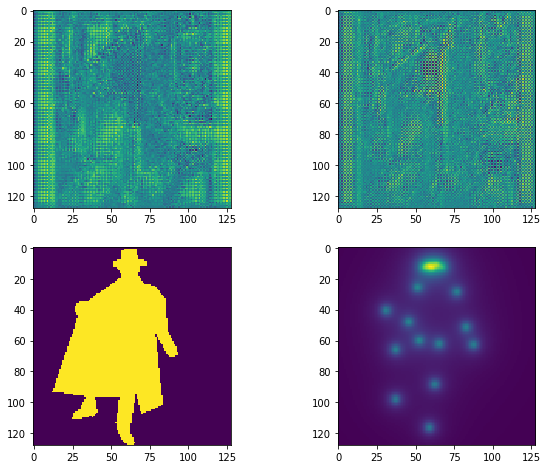

In [40]:
i = 3
plt.subplot(2,2,1)
plt.imshow(mask_pred[i][:,:,0])
plt.subplot(2,2,2)
plt.imshow(kpt_pred[i][:,:,0])

plt.subplot(2,2,3)
plt.imshow(masks[i][:,:,0])
plt.subplot(2,2,4)
plt.imshow(np.sum(kpt_masks[i],axis=2))

In [ ]:
def extract_annotations(filename, imgID, coco=coco):
    anns = coco.loadAnns(coco.getAnnIds(imgID,catIds=[1],iscrowd=None))
    ann = max([ann for ann in anns], key=lambda item:item['area']) # extract annotation for biggest instance
    bbox = np.array(np.floor(ann['bbox']),dtype=int)
    keypoints = np.reshape(ann['keypoints'],(-1,3))
    mask = coco.annToMask(ann)

    return filename, bbox, keypoints, mask

def preprocess_image_tf(filename, bbox_tensor, keypoints_tensor, mask, D = tf.constant(256.0)):
    """
    Returns:
    resized_image (N,D,D,3) - cropped, padded (if needed), scaled to square image of size D
    resized_mask (N,D,D,1) - cropped, padded (if needed), scaled to square mask of size D
    pts (N,2,17) - keypoint coordinates (i,j) scaled to match up with resized_image
    labels (N,1,17) - values corresponding to pts: {0: invalid, 1:occluded, 2:valid}
    """
    image_string = tf.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.cast(image_decoded, tf.float32)

    mask = tf.transpose([mask],[1,2,0])
    bbox_tensor = tf.to_float(bbox_tensor)
    keypoints_tensor = tf.to_float(keypoints_tensor)

    sideLength = tf.reduce_max(bbox_tensor[2:],axis=0)
    centerX = tf.floor(bbox_tensor[0] + tf.divide(bbox_tensor[2],tf.constant(2.0)))
    centerY = tf.floor(bbox_tensor[1] + tf.divide(bbox_tensor[3],tf.constant(2.0)))
    center = tf.stack([centerX,centerY])

    corner1 = tf.to_int32(tf.minimum(tf.maximum(tf.subtract(center, tf.divide(sideLength,tf.constant(2.0))),0),
                         tf.reverse(tf.to_float(tf.shape(image)[:2]),tf.constant([0]))))
    corner2 = tf.to_int32(tf.minimum(tf.maximum(tf.add(center, tf.divide(sideLength,tf.constant(2.0))),0),
                         tf.reverse(tf.to_float(tf.shape(image)[:2]),tf.constant([0]))))
    i_shape = tf.subtract(corner2,corner1)
    d_shape = tf.subtract(tf.to_int32(sideLength),i_shape)

    scale = tf.divide(D, sideLength)

    cropped_image = tf.image.crop_to_bounding_box(image,corner1[1],corner1[0],
                                                  tf.subtract(corner2,corner1)[1],tf.subtract(corner2,corner1)[0])
    cropped_mask = tf.image.crop_to_bounding_box(mask,corner1[1],corner1[0],
                                                  tf.subtract(corner2,corner1)[1],tf.subtract(corner2,corner1)[0])

    dX = tf.floor(tf.divide(d_shape,tf.constant(2)))
    dY = tf.ceil(tf.divide(d_shape,tf.constant(2)))

    pts, labels = tf.split(keypoints_tensor,[2,1],axis=1)
    pts = tf.subtract(pts,tf.to_float(corner1)) # shift keypoints
    pts = tf.add(pts,tf.to_float(dX)) # shift keypoints
    pts = tf.multiply(pts,scale) # scale keypoints
    
    # set invalid pts to 0
    inbounds = tf.less(pts,D)
    inbounds = tf.multiply(tf.to_int32(inbounds), tf.to_int32(tf.greater(pts,0)))
    pts = tf.multiply(pts,tf.to_float(inbounds))
    pts = tf.transpose(pts,[1,0])
    labels = tf.transpose(labels,[1,0])

    padded_image = tf.image.pad_to_bounding_box(cropped_image,tf.to_int32(dX[1]),tf.to_int32(dX[0]),
                                                tf.to_int32(sideLength),tf.to_int32(sideLength))
    padded_mask = tf.image.pad_to_bounding_box(cropped_mask,tf.to_int32(dX[1]),tf.to_int32(dX[0]),
                                                tf.to_int32(sideLength),tf.to_int32(sideLength))

    resized_image = tf.image.resize_images(padded_image,tf.constant([256,256]),tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    resized_image = resized_image - VGG_MEAN

    resized_mask = tf.image.resize_images(padded_mask,tf.constant([256,256]),tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return resized_image, resized_mask, pts, labels

def scaleDownMaskAndKeypoints(image, mask, pts, labels):
    mask = tf.image.resize_images(mask,tf.constant([128,128]),tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    pts = tf.multiply(pts,tf.constant(0.5))

    return image, mask, pts, labels

In [ ]:
# sess = tf.InteractiveSession()
sess = tf.Session()

In [ ]:
# Initialize train_dataset
VGG_MEAN = tf.reshape(tf.constant([123.68, 116.78, 103.94]),[1,1,3])

filenames = tf.constant(['{}/COCO_train2014_{:0>12}.jpg'.format(train_img_path,imgID) for imgID in imgIds])
imgID_tensor = tf.constant(imgIds)

train_dataset = tf.contrib.data.Dataset.from_tensor_slices((filenames,imgID_tensor))
# Extract Annotations via coco interface
train_dataset = train_dataset.map(lambda filename, imgID: tf.py_func(extract_annotations, [filename, imgID], 
                                                             [filename.dtype, tf.int64, tf.int64, tf.uint8]))
# All other preprocessing in tensorflow
train_dataset = train_dataset.map(preprocess_image_tf)
train_dataset = train_dataset.map(scaleDownMaskAndKeypoints)

# BATCH
train_dataset = train_dataset.shuffle(buffer_size=10000)
train_dataset = train_dataset.batch(10) # must resize images to make them match
iterator = tf.contrib.data.Iterator.from_structure(train_dataset.output_types,train_dataset.output_shapes)
# resized_image, resized_mask, pts, labels = iterator.get_next()
images, masks, pts, labels = iterator.get_next()
train_init_op = iterator.make_initializer(train_dataset)

In [ ]:
sess.run(train_init_op)
I, M, keypoints, L = sess.run([images, masks, pts, labels])

In [ ]:
keypoints.shape, L.shape

### Keypoint Loss

In [ ]:
# def keypointMask(keypoints, L = 10.0, D = 128.0, scope="keypointMask", num_kpts=17): # for applying mask over keypoints
#     batch_size = keypoints.get_shape().as_list()[0]
#     num_kpts = keypoints.get_shape().as_list()[2]

#     X, Y = tf.meshgrid(tf.linspace(0.0,128.0,128),tf.linspace(0.0,128.0,128))
#     X = tf.reshape(X,[1,128,128,1])
#     Y = tf.reshape(Y,[1,128,128,1])
#     X_stack = tf.tile(X,tf.constant([10,1,1,17],dtype=tf.int32))
#     Y_stack = tf.tile(Y,tf.constant([10,1,1,17],dtype=tf.int32))

#     pts = tf.reshape(keypoints,[-1,1,2,17])
#     ptsX, ptsY = tf.split(pts,[1,1],axis=2)
#     d1 = tf.square(tf.subtract(X_stack,ptsX))
#     d2 = tf.square(tf.subtract(Y_stack,ptsY))

#     y = tf.multiply(tf.divide(tf.constant(1.0),tf.add(d1,d2)+L),L)
#     return y

In [4]:
def keypoint_CrossEntropyLoss(prediction_maps, keypoint_masks, labels, L=5.0, scope="keypointLoss"):
    """
    heat_maps = predictions from network
    keypoints (N,17,2) = actual keypoint locations
    labels (N,17,1) = 0 if invalid, 1 if occluded, 2 if valid
    """
    losses = tf.nn.sigmoid_cross_entropy_with_logits(logits=prediction_maps,labels=keypoint_masks)
    labels = tf.reshape(labels,[-1,1,1,17])
    losses = tf.multiply(losses,labels) # set loss to zero for invalid keypoints (labels=0)
    
    return losses

In [ ]:
def keypoint_SquaredErrorLoss(prediction_maps, keypoint_masks, labels, L=5.0, scope="keypointLoss"):
    """
    heat_maps = predictions from network
    keypoints (N,17,2) = actual keypoint locations
    labels (N,17,1) = 0 if invalid, 1 if occluded, 2 if valid
    """
    losses = tf.squared_difference(prediction_maps,keypoint_masks)
    labels = tf.reshape(labels,[-1,1,1,17])
    losses = tf.multiply(losses,labels) # set loss to zero for invalid keypoints (labels=0)
    
    return losses

In [ ]:
sess = tf.InteractiveSession()

In [ ]:
BATCH_SIZE = 3
keypoints = tf.random_uniform([BATCH_SIZE,2,17],0,128)
labels = tf.to_float(tf.random_uniform([BATCH_SIZE,1,17],0,3,dtype=tf.int32))

# simulate predictions by adding error
predictions = tf.add(keypoints,tf.random_normal([BATCH_SIZE,2,17],0.0,1.0))

y = keypointMask(keypoints,L=10.0) # heatmaps for keypoint ground truth
y_flat = tf.reduce_sum(y,axis=3)

prediction_maps = keypointMask(predictions, L=5.0)
keypoint_cross_entropy_loss = keypoint_CrossEntropyLoss(prediction_maps, keypoints, labels, L=5.0)
keypoint_square_loss = keypoint_SquaredErrorLoss(prediction_maps, keypoints, labels, L=5.0)

In [ ]:
plt.figure(figsize=[16,4])

Y,P,SQ_Loss,CE_Loss = sess.run([y,prediction_maps,keypoint_square_loss,keypoint_cross_entropy_loss])

plt.subplot(1,4,1)
plt.imshow(Y[0,:,:,0])
plt.colorbar()
plt.axis("equal")
plt.xlim([0,128])
plt.ylim([0,128])

plt.subplot(1,4,2)
plt.imshow(P[0,:,:,0])
plt.colorbar()
plt.xlim([0,128])
plt.ylim([0,128])
plt.axis("equal")

plt.subplot(1,4,3)
plt.imshow(SQ_Loss[0,:,:,0])
plt.colorbar()
plt.xlim([0,128])
plt.ylim([0,128])
plt.axis("equal")

plt.subplot(1,4,4)
plt.imshow(CE_Loss[0,:,:,0])
plt.colorbar()
plt.xlim([0,128])
plt.ylim([0,128])
plt.axis("equal")


# Other Initialization Details

In [ ]:
is_training = tf.placeholder(tf.bool,name='is_training')

# Play around with ResNet

In [ ]:
graph = tf.Graph()
with graph.as_default():

    net, endpoints = resnet.resnet_v2_50(images,
                     num_classes=10,
                     is_training=True,
                     global_pool=False, # dense prediction
                     output_stride=None,
                     reuse=None,
                     scope='resnet_v2_50')
    branch_layer = endpoints['resnet_v2_50/block4/unit_1/bottleneck_v2/conv1']
    sess = tf.Session(graph=graph)
    
    file_writer = tf.summary.FileWriter('.', sess.graph)
    sess.run(train_init_op)

In [ ]:
vgg = tf.contrib.slim.nets.vgg
with slim.arg_scope(vgg.vgg_arg_scope(weight_decay=.9)):
    logits, _ = vgg.vgg_16(images, num_classes=50, is_training=is_training,dropout_keep_prob=.5)
    
model_path = '/Users/kyle/Documents/SCHOOL/Stanford/STANFORD_2016_to_2017/3rd_quarter/CS231N/Project/ExampleCode/vgg_16.ckpt'
assert(os.path.isfile(model_path))

variables_to_restore = tf.contrib.framework.get_variables_to_restore(exclude=['vgg_16/fc8','vgg_16/fc7','vgg_16/fc6'])
init_fn = tf.contrib.framework.assign_from_checkpoint_fn(model_path, variables_to_restore)
variables_to_restore

In [ ]:
vgg_head = variables_to_restore[-1]

In [ ]:
net = tf.layers.conv2d(vgg_head, filters=10,kernel_size=(3,3),strides=(1,1),padding='same')

In [ ]:
# Non frozen layer
fc8_variables = tf.contrib.framework.get_variables('vgg_16/fc8')
fc8_init = tf.variables_initializer(fc8_variables)
fc8_variables

In [ ]:
sess = tf.Session()
init_fn(sess)  # load the pretrained weights
# sess.run(fc8_init)  # initialize the new fc8 layer
sess.run(train_init_op)

In [ ]:
# resized_image, resized_mask, pts, labels = sess.run(next_element)

try:
    I, M, P, L = sess.run([images, masks, pts, labels], {is_training: True})
    plt.imshow(I[0])
    plt.imshow(M[0][:,:,0],alpha=0.5)
    plt.scatter(P[0][(np.reshape(L[0],-1)==2),0],P[0][(np.reshape(L[0],-1)==2),1],c="r")
except tf.errors.OutOfRangeError:
    sess.run(train_init_op)
    print("Reinitialized Dataset Iterator...")
    